In [1]:
from PIL import Image
import numpy as np



先下載 MNIST 資料


In [2]:
import os
import urllib
from urllib.request import urlretrieve
dataset = 'mnist.pkl.gz'
def reporthook(a,b,c):
    print("\rdownloading: %5.1f%%"%(a*b*100.0/c), end="")
    
if not os.path.isfile(dataset):
        origin = "https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz"
        print('Downloading data from %s' % origin)
        urlretrieve(origin, dataset, reporthook=reporthook)

In [3]:
import gzip
import pickle
with gzip.open(dataset, 'rb') as f:
    train_set, validation_set, test_set = pickle.load(f, encoding='latin1')

In [4]:
# 設定好訓練及測試資料
train_X, train_y = train_set
test_X, test_y = test_set
# 設定成我們的格式
train_X = train_X[..., None]
test_X = test_X[..., None]


In [5]:
# 有 10 種類別，輸入的是 784 維
print(train_X.shape)
np.unique(train_y)

(50000, 784, 1)


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [6]:
from IPython.display import display
def showX(X):
    int_X = (X*255).clip(0,255).astype('uint8')
    # N*784 -> N*28*28 -> 28*N*28 -> 28 * 28N
    int_X_reshape = int_X.reshape(-1,28,28).swapaxes(0,1).reshape(28,-1)
    display(Image.fromarray(int_X_reshape))
# 訓練資料， X 的前 20 筆
print(train_y[:20])
showX(train_X[:20])

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


In [8]:
W = np.random.normal(size=(10, 784))
b = np.random.normal(size=(10, 1))
n_data = train_X.shape[0]
# 紀錄 loss
loss_history = []
accuracy_history = []
for epoch in range(5000):    
    idx = np.random.choice(n_data, 600, replace=False)
    X = train_X[idx]
    y = train_y[idx]
    one_y = np.eye(10)[y][..., None]
    d = np.exp(W @ X + b)
    q = d/d.sum(axis=(1,2), keepdims=True)
    loss = -np.log(q[range(len(y)), y]).mean()
    loss_history.append(loss)
    accuracy = (q.argmax(axis=1).ravel() == y).mean()
    accuracy_history.append(accuracy)
    if epoch%100 == 0:
        print(epoch, accuracy, loss)
    grad_b_all = q - one_y
    grad_b = grad_b_all.mean(axis=0)
    grad_W_all = grad_b_all @ X.swapaxes(1,2)
    grad_W = grad_W_all.mean(axis=0)
    W -=  grad_W
    b -= grad_b    


0 0.09 17.764835287
100 0.755 1.13833712807
200 0.825 0.762992102635
300 0.851666666667 0.561329662976
400 0.866666666667 0.658354026957
500 0.853333333333 0.712423948752
600 0.893333333333 0.414015700454
700 0.85 0.58701392179
800 0.896666666667 0.40469607617
900 0.89 0.442037355411
1000 0.886666666667 0.442813599279
1100 0.875 0.47320761804
1200 0.88 0.48943102494
1300 0.911666666667 0.347448875524
1400 0.916666666667 0.386135596789
1500 0.865 0.507765164747
1600 0.9 0.415006406596
1700 0.896666666667 0.405012293672
1800 0.896666666667 0.409211386787
1900 0.895 0.419964462858
2000 0.86 0.52949605619
2100 0.893333333333 0.36827073734
2200 0.915 0.3292077021
2300 0.906666666667 0.37111165045
2400 0.89 0.407817163571
2500 0.905 0.326286179161
2600 0.935 0.280971971667
2700 0.893333333333 0.380322126367
2800 0.92 0.275207601672
2900 0.91 0.338209344189
3000 0.915 0.309544928356
3100 0.9 0.373026371915
3200 0.898333333333 0.375550731825
3300 0.901666666667 0.450186264758
3400 0.905 0.3429

In [14]:
# test data 的正確率
((W @ test_X + b).argmax(axis=1).ravel() == test_y).mean()

0.91579999999999995

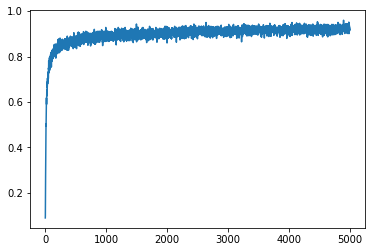

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
# 準確率的圖
plt.plot(accuracy_history);

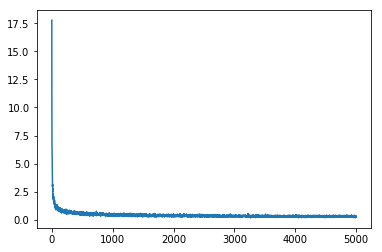

In [10]:
# loss 的圖
plt.plot(loss_history);

In [ ]:
accuracy_history = []
γ = 0.03
A = np.random.normal(size=(10,9))
b = np.random.normal(size=(10,1))
C = np.random.normal(size=(3,10))
d = np.random.normal(size=(3,1))

for epochs in range(500):
    for i in range(512):
        x = np.array([[(i>>j)&1] for j in range(9)])
        y = truth(x)
        U = relu(A@x+b)
        q = softmax(C@U+d)
        L = - np.log(q[y])
        p = np.eye(3)[y][:, None]
        grad_d = q - p
        grad_C = grad_d @ U.T
        grad_b = (C.T @ grad_d ) * Drelu(A@x+b)
        grad_A = grad_b @ x.T
        A -= γ * grad_A
        b -= γ * grad_b
        C -= γ * grad_C
        d -= γ * grad_d
    score = 0
    for i in range(512):
        x = np.array([[(i>>j)&1] for j in range(9)])
        x = np.array([[(i>>j)&1] for j in range(9)])        
        U = relu(A@x+b)
        q = softmax(C@U+d)
        score += q.argmax() == truth(x)
    accuracy_history.append(score/512)
    if epochs%20==0:
        print(epochs, score/512)